<a href="https://colab.research.google.com/github/zihadbappy/bnfake/blob/main/BanFakeNews_BNBanglaBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/zihadbappy/FakeDatasets.git

Cloning into 'FakeDatasets'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 20 (delta 8), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (20/20), done.


In [2]:
import pandas as pd
Dataset= pd.read_csv('/content/FakeDatasets/banfakenews_no_duplicate.csv')

In [3]:
df = pd.DataFrame(Dataset)

In [4]:
df=df.dropna(how='any',axis=0)

In [5]:
X=df.content
Y=df.label

In [6]:
df.groupby('label').agg('count')


,headline,content
label,,
0,1176,1176
1,1175,1175


In [7]:
Y.value_counts()

0    1176
1    1175
Name: label, dtype: int64

In [8]:
X.shape


(2351,)

In [9]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 31.2 MB/s 
     |████████████████████████████████| 120 kB 69.9 MB/s 
     |████████████████████████████████| 6.6 MB 61.7 MB/s 


In [10]:
import time

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
from transformers import BertModel, BertTokenizer, BertForSequenceClassification

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

In [11]:
class NewsDatasets(Dataset):
    def __init__(self, data, max_length=100):
        self.data = data
        
        self.config = {
            "max_length": max_length,
            "padding": "max_length",
            "return_tensors": "pt",
            "truncation": True,
            "add_special_tokens": True
        }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        value = self.data.iloc[idx]
        return value['headline']+"[SEP]"+value['content'] , value['label']

In [12]:
class NewsBert(nn.Module):

    def __init__(self, bert):
        super(NewsBert, self).__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.2)

        # relu activation function
        self.relu = nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768, 128)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(128, 2)  

    # define the forward pass
    def forward(self, input_ids, token_type_ids, attention_mask):
        # pass the inputs to the model
        out = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        x = self.fc1(out[1])
        x = self.relu(x)
        # output layer
        x = self.fc2(self.dropout(x))
        
        return x
      

In [13]:
bert_model_name = "sagorsarker/bangla-bert-base"
bert = BertModel.from_pretrained(bert_model_name)
tokenizer = BertTokenizer.from_pretrained(bert_model_name)


Downloading:   0%|          | 0.00/491 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/660M [00:00<?, ?B/s]

Some weights of the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/2.24M [00:00<?, ?B/s]

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NewsBert(bert)
model.to(device);

In [15]:
from torch.optim.lr_scheduler import StepLR

optimizer = AdamW(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

In [16]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.25, random_state=121, stratify=df['label'])

In [17]:
len(train_df), len(test_df)

(1763, 588)

In [18]:
training_data = NewsDatasets(train_df)
train_dataloader = DataLoader(training_data, batch_size=16, shuffle=True)

In [19]:
type(training_data)

__main__.NewsDatasets

In [20]:
test_data = NewsDatasets(test_df)
test_dataloader = DataLoader(test_data, batch_size=16, shuffle=True)

In [21]:
def evaluate(model, dataloader, criterion, config):
    total = 0
    correct = 0
    valid_loss = 0.0

    model.eval()  # prep model for evaluation
    for batch in dataloader:
        text, labels = batch
        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        output = model(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss_p = criterion(output, labels)
        # update running validation loss
        valid_loss += loss_p.item() * input_ids.size(0)
        # calculate accuracy
        proba = torch.exp(output)
        top_p, top_class = proba.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        # accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return total, correct, valid_loss

In [22]:
epochs = 8
tokenizer_config = {
    "max_length": 300,
    "padding": "max_length",
    "return_tensors": "pt",
    "truncation": True,
    "add_special_tokens": True
}

In [23]:
def train(model, dataloader, optimizer, criterion, config):
    model.train()  # prep model for training
    train_loss = 0
    for batch in tqdm(dataloader):
        text, labels = batch

        model.zero_grad()

        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        logs = model(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss = criterion(logs, labels)
        train_loss += loss.item() * input_ids.size(0)
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

    return train_loss

In [24]:
test_df

,headline,content,label
1379,চট্টগ্রামে অস্ত্রধারী সেই ছাত্রলীগ নেতার অস্ত্...,চট্টগ্রাম কলেজে সদ্য ঘোষিত ছাত্রলীগের কমিটি বা...,1
1390,আনোয়ার ইস্পাতের পরিবেশক সম্মেলন অনুষ্ঠিত,বুধবার প্রতিষ্ঠানের এক সংবাদ বিজ্ঞপ্তিতে ঢাকার...,1
1018,অলসদের জন্য এলো ঢুকাও অ্যাপস,অলস ভালো লাগেনা অলস আপনাকে মুখে খাবার জায়গায়...,0
553,যৌবনের মেয়াদ শেষ হলে তবেই গ্রামে ফিরবিভিডিও,ব্রিটিশ আমলের আইন বাতিল সুপ্রিম কোর্টের দেয়া র...,0
1978,দলে বিভ্রান্তি ছড়ানোর উদ্দেশ্যে বিএনপির প্রার...,একাদশ জাতীয় সংসদ নির্বাচন ঘিরে গণমাধ্যমে বিএনপ...,1
...,...,...,...
890,নিজেকে ছাগলের আব্বু বলে দাবী করলেন মেসি,সামনেই রাশিয়া বিশ্বকাপ আসর মিলতে চারিদিকে উৎস...,0
2304,বোলিংয়ে এসেই শাহজাদকে ফেরালেন সাকিব,ইনিংসের তম ওভারে প্রথমবারের সাকিব আল হাসানকে ব...,1
60,ইমরান খানের বিবাহ ভাঙ্গায় কারওয়ানবাজার ও গুলশা...,নিজস্ব মতিবেদকবিবাহের দশ মাসের মাথায় পাকিস্তান...,0
166,বিপিএলে দল কিনতে চান হিরো আলম,বিপিএলের এবারের আসরে যুক্ত হিরো আলম চলমান বিপি...,0


In [25]:
train_loss_data=[]
valid_loss_data = []
valid_loss_min = np.Inf
since = time.time()
best_loss = np.inf

for epoch in range(epochs):
  print("Epoch: {}/{}".format(epoch + 1, epochs))
  # monitor training loss
  train_loss = 0.0
  valid_loss = 0.0
  total = 0
  correct = 0
  e_since = time.time()

    # Train Model
  train_loss += train(model, train_dataloader, optimizer, criterion, tokenizer_config)
    # Now Evaluate
  out = evaluate(model, test_dataloader, criterion, tokenizer_config)
  total += out[0]
  correct += out[1]
  valid_loss += out[2]  
  scheduler.step()

    # print training/validation statistics
    # calculate average loss over an epoch
  train_loss = train_loss / len(train_dataloader.dataset)
  valid_loss = valid_loss / len(test_dataloader.dataset)

    # calculate train loss and running loss
  train_loss_data.append(train_loss * 100)
  valid_loss_data.append(valid_loss * 100)
    
  if valid_loss < best_loss:
    best_loss = valid_loss
    torch.save(model.state_dict(), "news_model1.pth")
    
  print("\tTrain loss:{:.6f}..".format(train_loss),
          "\tValid Loss:{:.6f}..".format(valid_loss),
          "\tAccuracy: {:.4f}".format(correct / total * 100))

time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

Epoch: 1/8


  0%|          | 0/111 [00:00<?, ?it/s]

	Train loss:0.511161.. 	Valid Loss:0.349283.. 	Accuracy: 88.0952
Epoch: 2/8


  0%|          | 0/111 [00:00<?, ?it/s]

	Train loss:0.316397.. 	Valid Loss:0.394357.. 	Accuracy: 84.5238
Epoch: 3/8


  0%|          | 0/111 [00:00<?, ?it/s]

	Train loss:0.209834.. 	Valid Loss:0.261544.. 	Accuracy: 90.9864
Epoch: 4/8


  0%|          | 0/111 [00:00<?, ?it/s]

	Train loss:0.175489.. 	Valid Loss:0.257029.. 	Accuracy: 91.4966
Epoch: 5/8


  0%|          | 0/111 [00:00<?, ?it/s]

	Train loss:0.161767.. 	Valid Loss:0.258141.. 	Accuracy: 91.4966
Epoch: 6/8


  0%|          | 0/111 [00:00<?, ?it/s]

	Train loss:0.154604.. 	Valid Loss:0.258889.. 	Accuracy: 91.1565
Epoch: 7/8


  0%|          | 0/111 [00:00<?, ?it/s]

	Train loss:0.152653.. 	Valid Loss:0.258727.. 	Accuracy: 91.1565
Epoch: 8/8


  0%|          | 0/111 [00:00<?, ?it/s]

	Train loss:0.157573.. 	Valid Loss:0.258459.. 	Accuracy: 91.3265
Training completed in 15m 58s


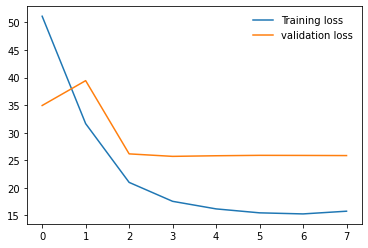

In [26]:
from matplotlib import pyplot as plt

plt.plot(train_loss_data, label="Training loss")
plt.plot(valid_loss_data, label="validation loss")
plt.legend(frameon=False)

In [27]:
model.load_state_dict(torch.load("./news_model1.pth", map_location = device))

<All keys matched successfully>

In [28]:
all_preds = []
all_labels = []

for batch in test_dataloader:
    text, labels = batch
    inputs = tokenizer.batch_encode_plus(
        text, **tokenizer_config
    )
    input_ids = inputs['input_ids'].to(device)
    token_type_ids = inputs['token_type_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    labels = labels.to(device)

    # move things to model
    output = model(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)
    preds = output.detach().cpu().numpy()
    preds = np.argmax(preds, axis = 1)
    all_preds.extend(preds)
    all_labels.extend(labels.cpu().numpy())

In [29]:
from sklearn.metrics import classification_report

# preds = np.argmax(preds, axis = 1)
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.92      0.91      0.91       294
           1       0.91      0.92      0.92       294

    accuracy                           0.91       588
   macro avg       0.92      0.91      0.91       588
weighted avg       0.92      0.91      0.91       588



In [30]:
all_labels[1000:1020]

[]

In [31]:
all_preds[1000:1020]

[]